# **Desarrollo** ***Travelling Salesman Problem*** **con** ***Particle Swarm Optimization***

In [ ]:
# Clonar repositorio
# !rm -rf tdo-tsp-pso/
!git clone https://github.com/cesara-montoya1/tdo-tsp-pso
!ln -s tdo-tsp-pso/{pso.py,util.py,maps,results} .

fatal: destination path 'tdo-tsp-pso' already exists and is not an empty directory.
ln: failed to create symbolic link './pso.py': File exists
ln: failed to create symbolic link './util.py': File exists
ln: failed to create symbolic link './maps': File exists
ln: failed to create symbolic link './results': File exists


In [ ]:
# Google Colab
if 'google.colab' in str(get_ipython()):
    # Ruta del proyecto en Google Drive
    # Instalar Gurobi
    %pip install gurobipy

In [ ]:
# Librerías
import json
import math
import os
import re
from collections import defaultdict
from itertools import combinations, product
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

from pso import PSO
from util import generate_cities, save_map, load_map, visualize_tsp

In [ ]:
# Crear carpetas si no existen
path = "."
maps_path = f"{path}/maps"
results_path = f"{path}/results"
Path(maps_path).mkdir(parents=True, exist_ok=True)
Path(results_path).mkdir(parents=True, exist_ok=True)

# Parámetros a evaluar
iterations = 2000
num_cities = [5, 10, 20, 30, 40, 50, 60]
population_size = [500, 2000, 6000]
pbest_probability = [0.02, 0.3, 0.5, 0.9]
gbest_probability = pbest_probability.copy()

# Bandera para no repetir la evaluación de parámetros
already_done = True

# Cargar los mapas
maps_files = {f"map_{n}.txt": 0 for n in num_cities}
for n in num_cities:
    filename = f"map_{n}.txt"
    if filename not in os.listdir(maps_path):
        save_map(f"{maps_path}/{filename}", generate_cities(n))
    maps_files[filename] = 0

parameters_grid = product(population_size, pbest_probability,
                          gbest_probability, maps_files.keys())

In [ ]:
def solve_with_pso(iterations, pop,
                   pbest, gbest, cities) -> PSO:
    pso = PSO(iterations=iterations, population_size=pop,
              pbest_probability=pbest, gbest_probability=gbest,
              cities=map)
    pso.run()
    return pso

def print_and_log(file, msg):
    print(msg, end="")
    file.write(msg)

# Estructuras de datos donde se almacenan los resultados
map_dict = defaultdict(list)
pop_dict = defaultdict(list)
pbest_dict = defaultdict(list)
gbest_dict = defaultdict(list)

# Listas de datos y nombres de archivos
result_data = [map_dict, pop_dict, pbest_dict, gbest_dict]
result_filenames = ["map_dict.json", "pop_dict.json",
                    "pbest_dict.json", "gbest_dict.json"]


## Realizar las pruebas con todos los parámetros

In [ ]:
if not already_done:
    for parameters in parameters_grid:
        # Extraer parametros, cargar mapa y hallar número de ciudades
        pop, pbest, gbest, map_file = parameters
        map = load_map(map_file)
        city_n = re.search(r'map_(\d+).*', map_file)
        city_n = int(city_n[1] if city_n is not None else 0)

        # Resolver con PSO y extraer el historial de distancias
        pso = solve_with_pso(iterations, pop, pbest, gbest, map)
        gcost_iter = pso.gcost_iter

        # Archivo de registro
        with open(f"{results_path}/log.txt", "a") as log:
            status_msg = f"PSO with pop: {pop}, pbest: {pbest}, gbest: {gbest}, cities: {city_n}\n"
            print_and_log(log, status_msg)
            exit_msg = f'Optimized cost is {pso.gbest.pbest_cost}\n'
            print_and_log(log, exit_msg)

        # Guardar datos
        map_dict[city_n].append(gcost_iter)
        pop_dict[pop].append(gcost_iter)
        pbest_dict[pbest].append(gcost_iter)
        gbest_dict[gbest].append(gcost_iter)

    # Guardar datos en almacenamiento persistente
    for data, filename in zip(result_data, result_filenames):
        with open(f"{results_path}/{filename}", 'w') as f:
            json.dump(data, f)

# Cargar datos desde el almacenamiento persistente
for index, filename in enumerate(result_filenames):
    with open(f"{results_path}/{filename}", 'r') as f:
        if index == 0:
            map_dict = json.load(f)
        if index == 1:
            pop_dict = json.load(f)
        if index == 2:
            pbest_dict = json.load(f)
        if index == 3:
            gbest_dict = json.load(f)

## Graficar la comparación de parámetros

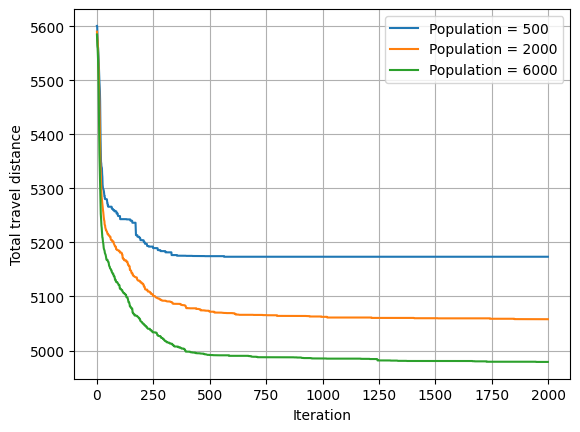

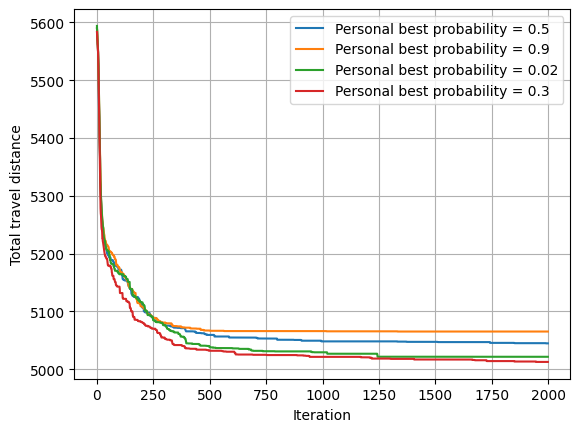

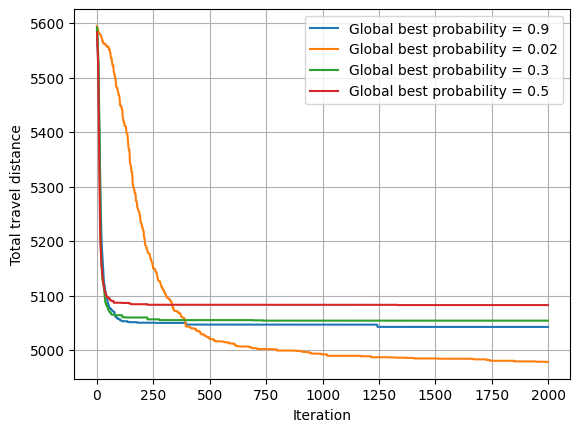

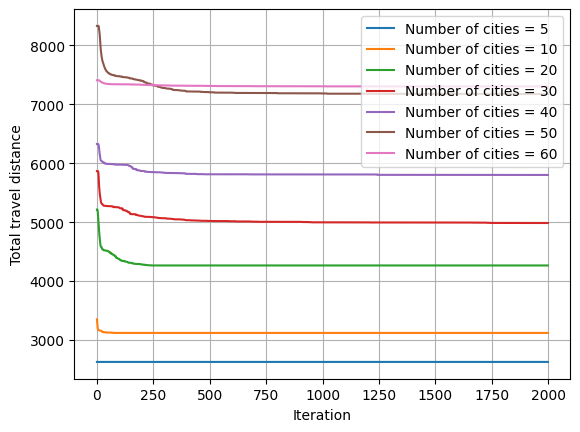

In [ ]:
def plot_comparison(data, label_fn):
    plt.figure()
    for key, value in data.items():
        avg_dist_evolution = np.mean(np.array([*value]), axis=0)
        plt.plot(avg_dist_evolution, label=label_fn(key))
    plt.ylabel("Total travel distance")
    plt.xlabel("Iteration")
    plt.grid()
    plt.legend()
    plt.show()

plot_comparison(pop_dict, lambda s: f"Population = {s}")
plot_comparison(pbest_dict, lambda s: f"Personal best probability = {s}")
plot_comparison(gbest_dict, lambda s: f"Global best probability = {s}")
plot_comparison(map_dict, lambda s: f"Number of cities = {s}")

Initial cost is 2627.871649701817
Optimized cost is 2627.871649701817


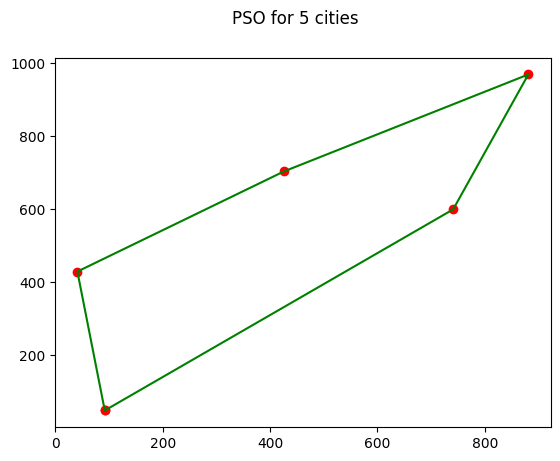

Initial cost is 3308.435539785116
Optimized cost is 3119.854018802484


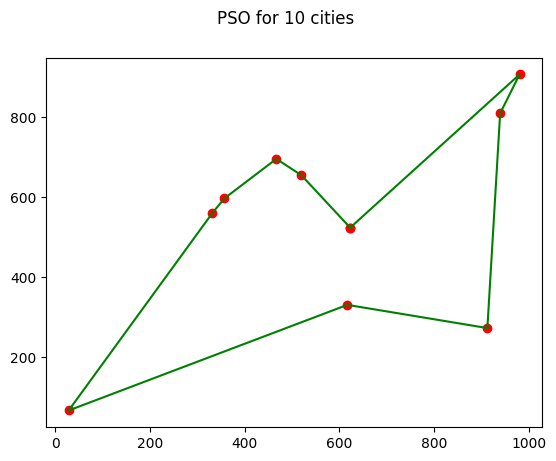

Initial cost is 5214.360409146473
Optimized cost is 4089.911473523355


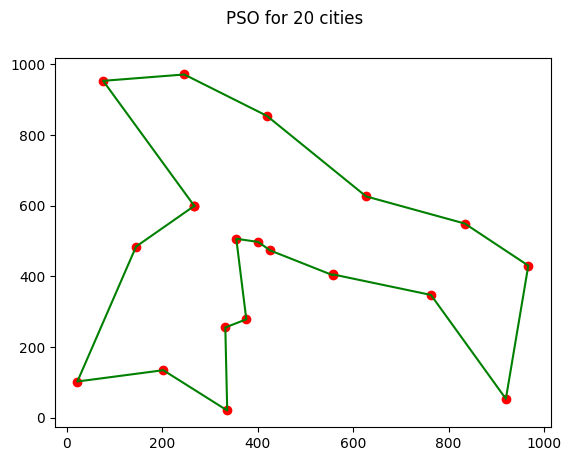

Initial cost is 5865.966687807921
Optimized cost is 4398.859471097191


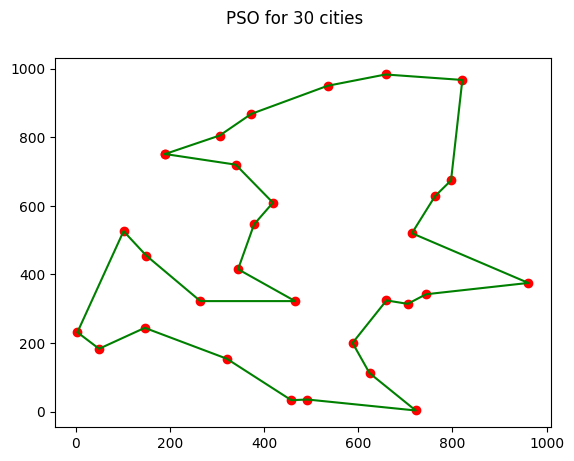

Initial cost is 6326.286310330309
Optimized cost is 5414.944455718925


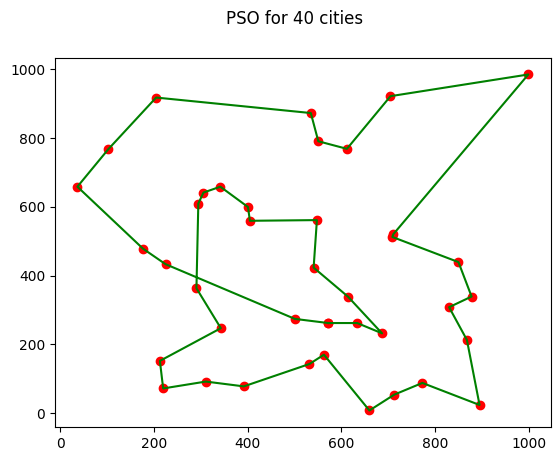

Initial cost is 8329.913308095349
Optimized cost is 6823.185286073405


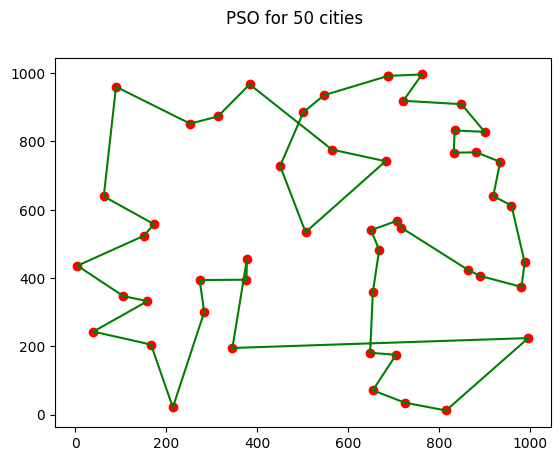

Initial cost is 7407.69816168893
Optimized cost is 7231.131554859216


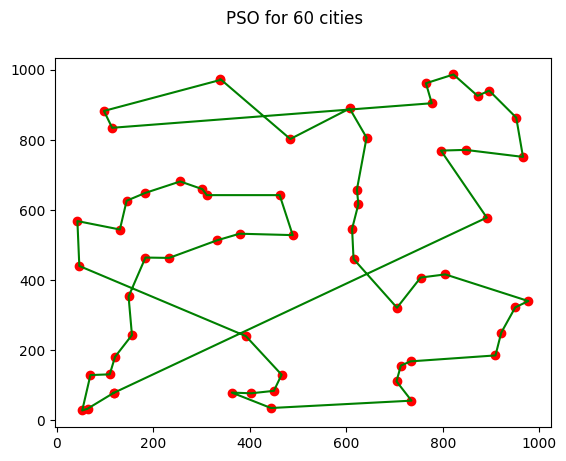

In [ ]:
# Parámetros con mejores resultados
iterations = 2000
best_population = 6000
best_pb = 0.3
best_gb = 0.02

# PSO a todos los mapas
for map_file in maps_files:
    map = load_map(f"{maps_path}/{map_file}")
    city_n = re.search(r'map_(\d+).*', map_file)
    city_n = int(city_n[1] if city_n is not None else 0)
    pso = solve_with_pso(iterations, best_population,
                         best_pb, best_gb, map)
    print(f"Optimized cost is {pso.gbest.pbest_cost}")
    visualize_tsp(f"PSO for {city_n} cities", pso.gbest.pbest)

# **Desarrollo** ***Travelling Salesman Problem*** **con** ***Gurobi***

In [ ]:
# Asignar una etiqueta a cada ciudad
def assign_names(map):
    return {f'c{i+1}': city for i, city in enumerate(map)}

# Calcular las distancias entre pares de ciudades
def distance(city1, city2, coordinates):
    c1 = coordinates[city1]
    c2 = coordinates[city2]
    diff = (c1.x-c2.x, c1.y-c2.y)
    return math.sqrt(diff[0]*diff[0]+diff[1]*diff[1])

# Preparar la estructura de datos del mapa
def prepare_map(map):
    coordinates = assign_names(map)
    capitals = list(coordinates.keys())
    dist = {(c1, c2): distance(c1, c2, coordinates) for c1, c2 in combinations(capitals, 2)}
    return coordinates, capitals, dist

# Callback - usar restricciones lazy para eliminar sub-tours
def subtourelim(model, where, capitals):
    if where == GRB.Callback.MIPSOL:
        # Hacer una lista de los nodos seleccionados en la solución
        vals = model.cbGetSolution(model._vars)
        selected = gp.tuplelist((i, j) for i, j in model._vars.keys()
                             if vals[i, j] > 0.5)
        # Encontrar el ciclo más corto en la lista seleccionada de nodos
        tour = subtour(selected, capitals)
        if len(tour) < len(capitals):
            # Añadir restricción para eliminar subtours, para cada par de ciudades
            model.cbLazy(gp.quicksum(model._vars[i, j] for i, j in combinations(tour, 2))
                         <= len(tour)-1)

# Encontrar el subtour más corto
def subtour(edges, capitals):
    unvisited = capitals[:]
    cycle = capitals[:]
    while unvisited:
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(thiscycle) <= len(cycle):
            cycle = thiscycle
    return cycle

# Obtener tour óptimo del modelo
def get_tour(model, capitals):
    vars = model._vars
    vals = model.getAttr('x', vars)
    selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)

    tour = subtour(selected, capitals)
    assert len(tour) == len(capitals)
    return tour

# Graficar tour óptimo
def plot_tour(model, coordinates, capitals, title):
    fig = plt.figure()
    fig.suptitle(title)

    tour = get_tour(model, capitals)
    pointsx = []
    pointsy = []
    for city in tour:
      pointsx.append(coordinates[city].x)
      pointsy.append(coordinates[city].y)
    pointsx.append(pointsx[0])
    pointsy.append(pointsy[0])

    plt.plot(pointsx, pointsy, "bo")
    plt.plot(pointsx, pointsy, "m")
    plt.show(block=True)

# Resolver el TSP con Gurobi
def solve_with_gurobi(map):
    # Preparar datos
    coordinates, capitals, dist = prepare_map(map)

    city_n = re.search(r'map_(\d+).*', map_file)
    city_n = int(city_n[1] if city_n is not None else 0)

    # Inicializar instancia del modelo
    m = gp.Model()

    # Definir variables y restricciones
    # ¿Es la ciudad i-ésima adyacente a la ciudad j-ésima en la ruta?
    vars = m.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='x')

    # Dirección simétrica
    vars.update({(j,i):vars[i,j] for i,j in vars.keys()})

    # Dos vértices incidentes en cada ciudad
    cons = m.addConstrs(vars.sum(c, '*') == 2 for c in capitals)

    m._vars = vars
    m.Params.lazyConstraints = 1
    m.optimize(lambda model, where: subtourelim(model, where, capitals))

    plot_tour(m, coordinates, capitals, f"Gurobi for {city_n} cities")

    return m

Restricted license - for non-production use only - expires 2025-11-24
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 5 rows, 10 columns and 20 nonzeros
Model fingerprint: 0xdaa6c6fc
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.00s
Presolved: 5 rows, 10 columns, 20 nonzeros
Variable types: 0 continuous, 10 integer (10 binary)
Found heuristic solution: objective 2759.3166734
Found heuristic solution: objective 2627.8716497

Root relaxation: cutoff, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |    

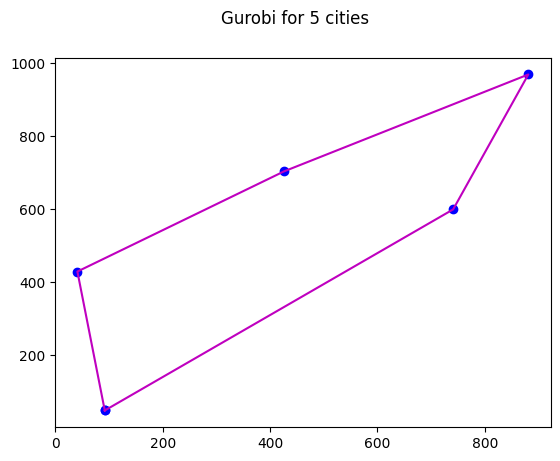

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 10 rows, 45 columns and 90 nonzeros
Model fingerprint: 0x50d376eb
Variable types: 0 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.00s
Presolved: 10 rows, 45 columns, 90 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)

Root relaxation: objective 3.119854e+03, 18 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    3119.8540188 3119.85402  0.00%   

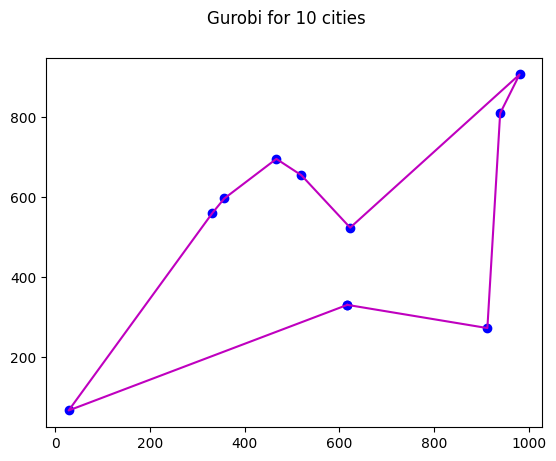

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 20 rows, 190 columns and 380 nonzeros
Model fingerprint: 0x43176e12
Variable types: 0 continuous, 190 integer (190 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.00s
Presolved: 20 rows, 190 columns, 380 nonzeros
Variable types: 0 continuous, 190 integer (190 binary)

Root relaxation: objective 3.994514e+03, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3994.51357    0    -          - 3994.51357  

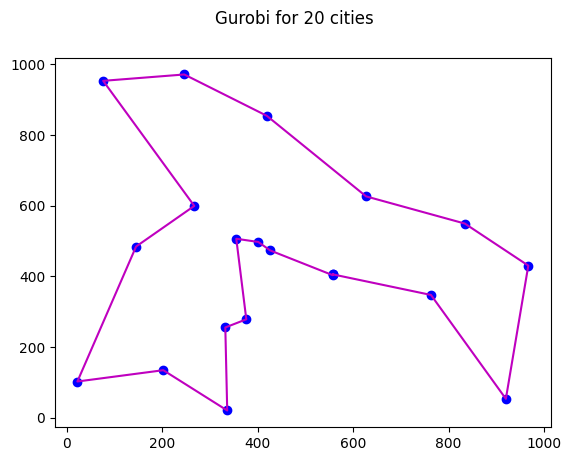

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 30 rows, 435 columns and 870 nonzeros
Model fingerprint: 0x1991d581
Variable types: 0 continuous, 435 integer (435 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.00s
Presolved: 30 rows, 435 columns, 870 nonzeros
Variable types: 0 continuous, 435 integer (435 binary)

Root relaxation: objective 4.270174e+03, 46 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4270.17431    0    6          - 4270.17431  

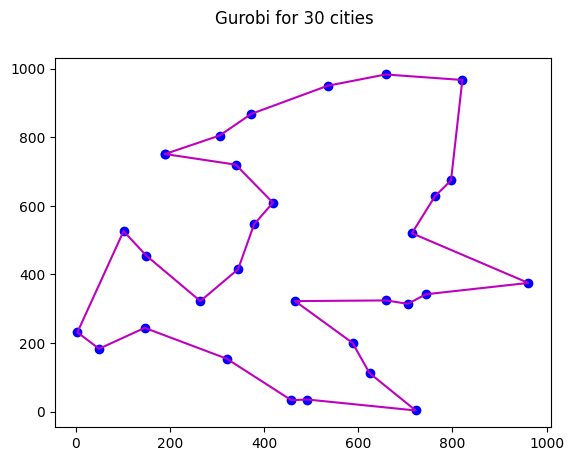

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 40 rows, 780 columns and 1560 nonzeros
Model fingerprint: 0xe171ca9a
Variable types: 0 continuous, 780 integer (780 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.01s
Presolved: 40 rows, 780 columns, 1560 nonzeros
Variable types: 0 continuous, 780 integer (780 binary)

Root relaxation: objective 4.909782e+03, 59 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4909.78229    0    -          - 4909.78229

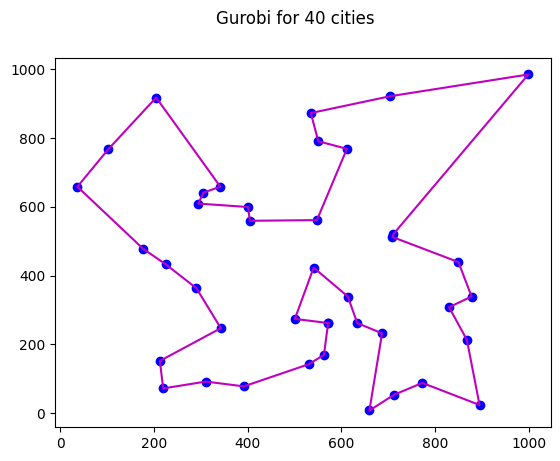

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 50 rows, 1225 columns and 2450 nonzeros
Model fingerprint: 0xbda3d014
Variable types: 0 continuous, 1225 integer (1225 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 25432.411281
Presolve time: 0.01s
Presolved: 50 rows, 1225 columns, 2450 nonzeros
Variable types: 0 continuous, 1225 integer (1225 binary)

Root relaxation: objective 5.735361e+03, 70 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



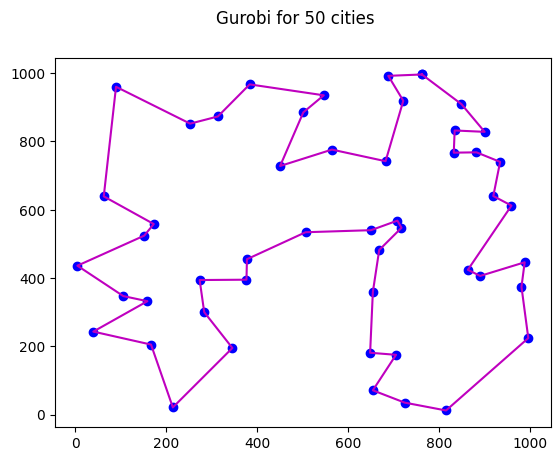

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 60 rows, 1770 columns and 3540 nonzeros
Model fingerprint: 0x4a7cd8fc
Variable types: 0 continuous, 1770 integer (1770 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.01s
Presolved: 60 rows, 1770 columns, 3540 nonzeros
Variable types: 0 continuous, 1770 integer (1770 binary)

Root relaxation: objective 5.452408e+03, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5452.40795    0   12          - 5452

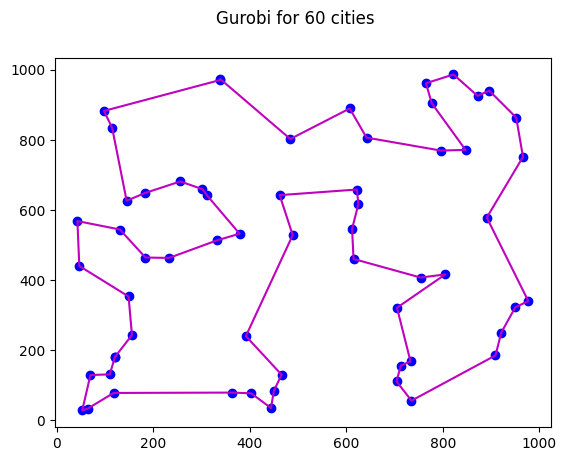

In [ ]:
# Gurobi a todos los mapas
for map_file in maps_files:
    map = load_map(f"{maps_path}/{map_file}")
    m = solve_with_gurobi(map)